<a href="https://colab.research.google.com/github/Sylar257/Google-Cloud-Platform-with-Tensorflow/blob/master/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These code suppose to be run in a GCP instance. The instructions to set up such a instance
is documented in the *README* [file](https://github.com/Sylar257/Google-Cloud-Platform-with-Tensorflow/blob/master/READNE.md) of thie Repo.

## Exploratory Data Analysis
In this notebook, we will be performing EDA on a *natality* dataset from google *BigQuery*

In [0]:
# change these to try this notebook out
BUCKET = 'example_bucket_26_11'      # CHANGE this to a globally unique value. Your project name is a good option to try.
PROJECT = 'qwiklabs-gcp-00-09dd6f655043'     # CHANGE this to your project name
REGION = 'australia-southeast1-a'    # CHANGE this to one of the regions supported by Cloud AI Platform https://cloud.google.com/ml-engine/docs/tensorflow/regions

In [0]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

### Loading the data
Use **SQL** query to access the natality data("LIMIT 1000"), and create a **`Pandas` dataframe** to contain our query data.<br>
The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother. Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [3]:
# Folllowing three lines of code allows you to run it within colab as well
from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


In [0]:
%load_ext google.colab.data_table

In [0]:
project_id = 'qwiklabs-gcp-00-36eabeb083f7'
from google.cloud import bigquery


In [6]:
import pandas as pd
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
LIMIT 200
"""
sample_count = 2000
df = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.063611,True,32,1,37.0,7108882242435606404
1,4.687028,True,30,3,33.0,7170969733900686954
2,7.561856,True,20,1,39.0,6392072535155213407
3,7.561856,True,31,1,37.0,2126480030009879160
4,7.312733,True,32,1,40.0,3408502330831153141


#### Take a look at the relationship between "gender", "number_of_babies" and "average weight"

In [0]:
# Create a function that finds any one of the feature's corelation with average weight and number of babies
def get_distinct_values(column_name):
    # {0} refers to the first input variable. In this case, "column_name"
    # This happens because the .format() at the end
    query = """
    SELECT
        {0},
        COUNT(1) AS num_babies,
        AVG(weight_pounds) AS avg_wt
    FROM
        publicdata.samples.natality
    WHERE
        year>2000
    GROUP BY
        {0}
    """.format(column_name)
    return pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,is_male,num_babies,avg_wt
0,False,16245054,7.104715
1,True,17026860,7.349797


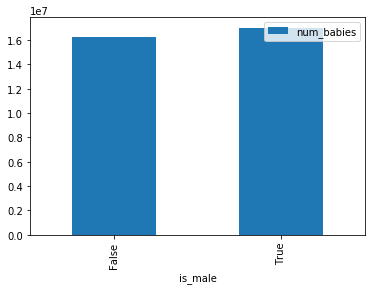

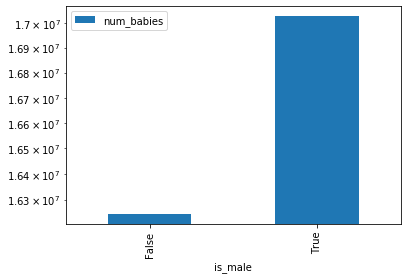

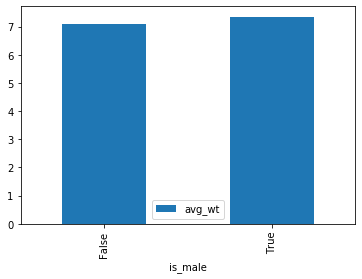

In [13]:
# plot and see the corelation of our target("weight_pounds") with other features

# call on the 'is_male' column
df = get_distinct_values('is_male')
df.plot(x='is_male', y='num_babies', kind='bar');
df.plot(x='is_male', y='num_babies', logy=True, kind='bar'); # take log on the y value
df.plot(x='is_male', y='avg_wt', kind='bar');

df.head()

,mother_age,num_babies,avg_wt
30,10,3,7.533195
44,11,44,6.149945
22,12,1196,6.506330
6,13,7552,6.656063
14,14,44868,6.743684


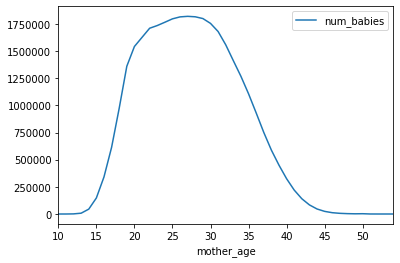

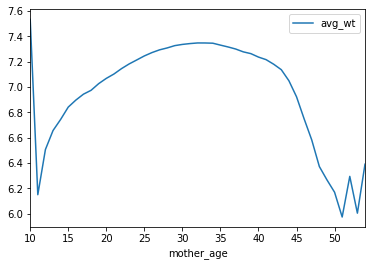

In [17]:
# use line plot to explore mother's age's corelation with num_babies and baby weight
df = get_distinct_values('mother_age')
df.sort_values('mother_age',ascending=True, inplace=True)
df.plot(x='mother_age', y='num_babies');
df.plot(x='mother_age', y='avg_wt');
df.head() # mother_age is sorted in ascending order(inplace)

## Note on mother's age
it's obvious that there is a non-linear corelation between mother's age and the `num_babies` & `baby_weight`. <br>
Thus, this is definetly a feature that we should exploit later when building our model

,plurality,num_babies,avg_wt
0,1,32159762,7.304663
2,2,1056305,5.144866
4,3,51913,3.688442
1,4,3337,2.848459
3,5,597,2.515053


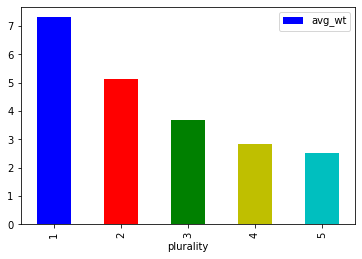

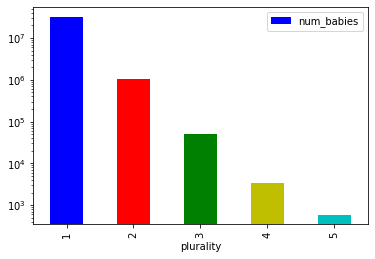

In [32]:
# Bar plot the number of babies the mother had for that birth giving

df = get_distinct_values('plurality')
df.sort_values('plurality', ascending=True, inplace=True)
df.plot(x='plurality', y='avg_wt', kind='bar', color=('b', 'r', 'g', 'y', 'c'))
df.plot(x='plurality', y='num_babies', logy=True, kind='bar',color=('b', 'r', 'g', 'y', 'c'))
df.head() # see that `plurality` is sorted in ascending order(inplace)

#### Note
Again very strong corelation here. Almost a linear relationship

,gestation_weeks,num_babies,avg_wt
22,17.0,2336,0.978025
15,18.0,3905,0.884395
14,19.0,6278,0.810890
27,20.0,10847,1.001574
28,21.0,14682,1.111511


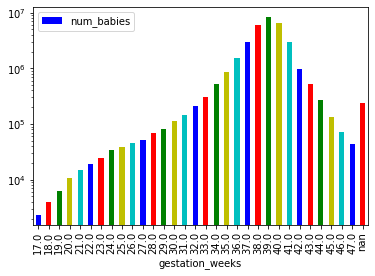

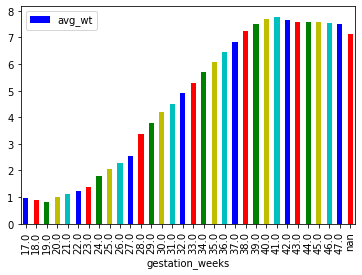

In [34]:
# Bar plot to see gestation_weeks with avg_wt and num_babies(in logy)
df = get_distinct_values('gestation_weeks')
df.sort_values('gestation_weeks', ascending=True, inplace=True)
df.plot(x='gestation_weeks', y='num_babies', logy=True, kind='bar', color=('b', 'r', 'g', 'y', 'c'))
df.plot(x='gestation_weeks', y='avg_wt', kind='bar',color=('b', 'r', 'g', 'y', 'c'))
df.head()

Again `gestation_weeks` is definetely another feature we should include in our models